In [5]:
import os
import gc
import PIL
import pytz
import time
import shutil
import random
%pip install split-folders
import splitfolders
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from collections import Counter
from datetime import datetime,timezone
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix,classification_report
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
  except RuntimeError as e:
    # Visible devices must be set at program startup
    print(e)

from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
input_dir = '/content/drive/MyDrive/Cyclone_Wildfire_Flood_Earthquake'
output_dir =  "/content/drive/MyDrive/Cyclone_Wildfire_Flood_Earthquake/dataset"
#splitfolders.ratio(input_dir, output=output_dir, seed=1337, ratio=(.7,.15,.15), group_prefix=None)


In [7]:
DATADIR = output_dir
TRAIN_DATADIR = os.path.join(DATADIR, 'train')
TEST_DATADIR = os.path.join(DATADIR, 'test')
VAL_DATADIR = os.path.join(DATADIR, 'val')

In [8]:
CATEGORIES = []
for c in os.listdir(TRAIN_DATADIR):
    CATEGORIES.append(c)
print(CATEGORIES)

['Flood', 'Earthquake', 'Cyclone', 'Wildfire']


In [9]:
plt.figure(figsize=(20,20))
i=0
for c in CATEGORIES:  
    path = os.path.join(TRAIN_DATADIR,c)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.subplot(len(CATEGORIES),5,i+1)
        plt.imshow(img_array)
        if i%5 == 0:
            plt.ylabel(c)
        plt.xticks([])
        plt.yticks([])
        i += 1
        if i%5 == 0:
            break
plt.tight_layout()        
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [10]:
IMG_SHAPE = (224,224,3)


In [11]:
def min_max_scalar(img, scale_range =(0, 1)):
    
    px_min = scale_range[0]
    px_max = scale_range[1]
    img = img.astype('float32')
    img = img/img.max()
    scaled_img = img * (px_max - px_min) + px_min
    return scaled_img

def resize(img,size):
    resized_img = img.resize(size, Image.ANTIALIAS)
    resized_img_array = np.asarray(resized_img)
    return resized_img_array

def del_corrupted_images(filepaths):
    del_count = 0
    for filepath in filepaths:
        try:
            fobj = open(filepath,'rb')
            is_JFIF =  b'JFIF' in fobj.peek(10)
        finally:
            fobj.close()
        if not is_JFIF:
            del_count += 1
            os.remove(filepath)
    print(f"Total {del_count} corrupted image deleted")
    return None

def find_filepaths(root_folder):
    filepaths = []
    for dirname, _, filenames in os.walk(root_folder):
        for filename in filenames:
            filepaths.append(os.path.join(dirname, filename))
    return filepaths

In [12]:
def load_and_prepare_dataset(dataset_dir,IMG_SHAPE):
    
    rock_classes = os.listdir(dataset_dir)
    
    filepaths = find_filepaths(dataset_dir)
    no_of_total_images = len(filepaths)
    
    data = np.zeros((no_of_total_images,*IMG_SHAPE),dtype='float32')
    label = []
    ix = 0
    
    for class_label in rock_classes:
        class_path = os.path.join(dataset_dir, class_label)
        for img in os.listdir(class_path):
            image = Image.open(os.path.join(class_path, img))
            resized_image = resize(image,IMG_SHAPE[:-1])
            image_array = min_max_scalar(resized_image)
            if image_array.shape == IMG_SHAPE:
                data[ix]=image_array
                label.append(class_label)
            else:
                image_array=np.stack((image_array,)*3, axis=-1)
                data[ix]=image_array
                label.append(class_label)
            ix += 1
    label = np.asarray(label)
    label = label.reshape((-1,1))
        
    return data,label

In [13]:
X_train,y_train = load_and_prepare_dataset(TRAIN_DATADIR,IMG_SHAPE)
X_val,y_val = load_and_prepare_dataset(VAL_DATADIR,IMG_SHAPE)
X_test,y_test = load_and_prepare_dataset(TEST_DATADIR,IMG_SHAPE)

In [14]:
print(f"Shape of X_train = {X_train.shape}")
print(f"Shape of y_train = {y_train.shape}")
print(f"Shape of X_val = {X_val.shape}")
print(f"Shape of y_val = {y_val.shape}")
print(f"Shape of X_test = {X_test.shape}")
print(f"Shape of y_test = {y_test.shape}")

Shape of X_train = (3097, 224, 224, 3)
Shape of y_train = (3097, 1)
Shape of X_val = (662, 224, 224, 3)
Shape of y_val = (662, 1)
Shape of X_test = (668, 224, 224, 3)
Shape of y_test = (668, 1)


In [15]:
def show_unique_images(X,y,idx=0):
    y = np.squeeze(y)
    unique = np.unique(y)
    index=[]
    for i in unique:
        try:
            r = np.where(y==i)
            index.append (r[0][idx])
        except:
            pass
    
    images=[]
    labels=[]
    for i in index:
        images.append(X[i])
        labels.append(y[i])
    
    plt.figure(figsize=(16,9))
    
    for i in range(np.unique(y).size):
        ax = plt.subplot(1,8, i+1)
        
        plt.imshow(images[i])
        plt.title(labels[i])
        plt.axis("off")
        
    return None

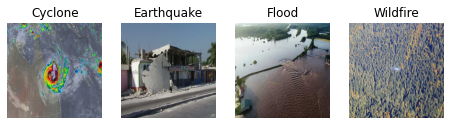

In [16]:
show_unique_images(X_train,y_train)

In [17]:
classes = Counter(np.squeeze(y_train).tolist()).keys()
values = Counter(np.squeeze(y_train).tolist()).values()
rock_count_per_class_before_smote = dict(zip(classes,values))
print(rock_count_per_class_before_smote)

{'Flood': 751, 'Earthquake': 944, 'Cyclone': 649, 'Wildfire': 753}


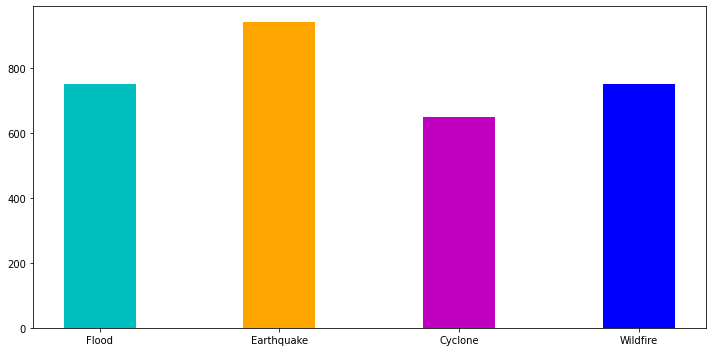

In [18]:
fig = plt.figure(figsize = (10, 5))
 
rock_names = list(rock_count_per_class_before_smote.keys())
rock_counts = list(rock_count_per_class_before_smote.values())
plt.bar(rock_names,rock_counts,color =['c','orange','m','b','g','r','maroon'],width = 0.4)
plt.tight_layout()  

In [19]:
def one_hot_encoder(array):
    encoded_array = []
    unique = np.unique(array)
    for item in array:
        encoded_item = item == unique
        encoded_array.append(encoded_item)
    encoded_array = np.asarray(encoded_array)
    encoded_array = encoded_array.astype(int)
    return encoded_array

In [20]:
y_train_encoded = one_hot_encoder(y_train)
y_val_encoded = one_hot_encoder(y_val)
y_test_encoded = one_hot_encoder(y_test)

In [21]:
class PrettyPrint(tf.keras.callbacks.Callback):
    
    def __init__(self,batches):
        super(PrettyPrint,self).__init__()
        self.batches = batches
        self.lr = None

    
    def print_in_color(self,txt_msg,fore_tupple,back_tupple,):
        #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
        #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
        rf,gf,bf=fore_tupple
        rb,gb,bb=back_tupple
        msg='{0}' + txt_msg
        mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
        print(msg .format(mat), flush=True)
        print('\33[0m', flush=True) # returns default print color to back to black
        return None

    def on_train_begin(self, logs=None):
        msg=f"{'Epoch':^10s}{'Train_Loss':^12s}{'Train_Acc':^12s}{'Val_Loss':^12s}{'Val_Acc':^12s}{'LR':^12s}{'Duration':^10s}"
        self.print_in_color(msg, (0, 255, 76), (55,65,80))
        self.lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))

        
    def on_train_end(self, logs=None):
        msg='Training is completed - model is set with weights for the epoch with the lowest loss'
        self.print_in_color(msg,  (255,100,255), (55,65,80))
        
    def on_train_batch_end(self, batch, logs=None):
        acc=logs.get('accuracy')* 100  # get training accuracy 
        loss=logs.get('loss')
        msg='{0:20s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='') # prints over on the same line to show running batch count
        
    def on_epoch_begin(self,epoch, logs=None):
        self.start_time = time.time()
        
    def on_epoch_end(self, epoch, logs=None):
        end_time =time.time()
        duration = end_time-self.start_time
        
        lr = self.lr
        current_lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
        if self.lr != current_lr:
            self.lr = current_lr 
            
        train_acc = logs.get('accuracy')*100
        train_loss = logs.get('loss')
        val_acc = logs.get('val_accuracy')*100
        val_loss =logs.get('val_loss')
        
        msg = f"{str(epoch+1):^10s}{train_loss:^12.3f}{train_acc:^12.3f}{val_loss:^12.5f}{val_acc:^12.5f}{lr:^12.9f}{duration:^10.3f}"
        self.print_in_color (msg,(0,255,255), (55,65,80))

In [22]:
print(X_train.shape[0]==y_train_encoded.shape[0])
print(type(X_train) == type(y_train_encoded))
print(X_train.shape)
print(y_train_encoded.shape)
print(X_val.shape)
print(y_val_encoded.shape)

True
True
(3097, 224, 224, 3)
(3097, 4)
(662, 224, 224, 3)
(662, 4)


In [23]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.regularizers import l1_l2

In [24]:
BaseModel = InceptionV3(weights='imagenet', include_top=False, input_shape= IMG_SHAPE )

87924736/87910968 [==============================] - 1s 0us/step


In [25]:
output_size = len(y_train_encoded[0])
print(f"Output Size = {output_size}")

Output Size = 4


In [26]:
model = Sequential()

model.add(BaseModel)

model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu',
                kernel_regularizer=l1_l2(0.01),
                bias_regularizer=l1_l2(0.01)))

model.add(BatchNormalization())
model.add(Dropout(.3))
model.add(Dense(output_size, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 batch_normalization_94 (Bat  (None, 51200)            204800    
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 256)               13107456  
                                                                 
 batch_normalization_95 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 256)               0

In [27]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adamax(learning_rate=0.001),
              metrics=['accuracy']) 

In [28]:
batch_size = 64
train_steps=int(len(y_train)/batch_size)
batches=train_steps

color_print = PrettyPrint(batches)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.5,
                                                 patience=1,verbose=0)
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5,verbose=0,
                                              restore_best_weights=True)

callbacks = [color_print,reduce_lr,early_stop]

In [30]:
history = model.fit(X_train,y_train_encoded, 
                    validation_data=(X_val,y_val_encoded),
                    batch_size=batch_size, epochs=30,verbose=0,
                    callbacks=callbacks)

  Epoch    Train_Loss  Train_Acc    Val_Loss    Val_Acc        LR      Duration 

    1       143.444      86.212     23.27867    39.57704  0.001000000   51.898  

    2        16.809      93.800     14.94592    64.95468  0.001000000   23.943  

    3        11.529      97.481     11.51661    86.10272  0.001000000   24.628  

    4        10.397      98.321     9.36587     69.63746  0.001000000   25.205  

    5        9.540       98.773     9.85303     94.56193  0.001000000   24.807  

    6        5.571       98.934     5.42001     94.56193  0.001000000   24.701  

    7        4.655       99.548     5.05030     46.82779  0.000500000   24.998  

    8        4.270       99.613     5.75596     72.50755  0.000500000   25.005  

    9        2.841       99.645     3.97421     47.58308  0.000500000   24.869  

    10       2.561       99.451     5.04773     92.90030  0.000250000   24.983  

    11       2.305       99.742     2.53654     38.21752  0.000250000   26.130  

    12       0.9

In [31]:
def plot_accuracy_loss(history):
    f,ax = plt.subplots(1,2,figsize=(12,6))
    
    ax[0].plot([None]+history.history['accuracy'],'o-')
    ax[0].plot([None]+history.history['val_accuracy'],'o-')
    ax[0].legend(['Train Accuracy','Validation Accuracy'],loc = 0)
    ax[0].set_title('Training & Validation accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')

    ax[1].plot([None]+history.history['loss'],'o-')
    ax[1].plot([None]+history.history['val_loss'],'o-')
    ax[1].legend(['Training Loss','Validation Loss'],loc = 0)
    ax[1].set_title('Training & Validation loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    
    plt.style.use('ggplot')
    plt.tight_layout()
    plt.show()
    
    return None

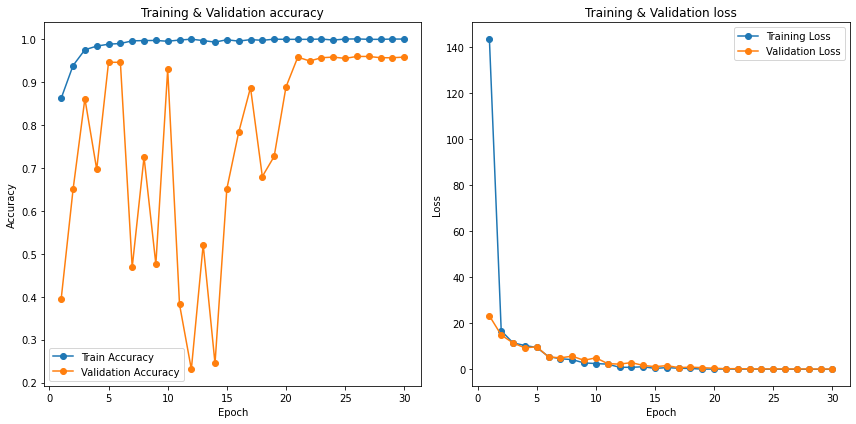

In [32]:
plot_accuracy_loss(history)

In [33]:
result = model.evaluate(X_test,y_test_encoded)
print(result)

21/21 [==============================] - 4s 134ms/step - loss: 0.1717 - accuracy: 0.9626
[0.17168770730495453, 0.96257483959198]


In [34]:
def label_encoder(string):
    _classes = ['Flood', 'Earthquake', 'Cyclone', 'Wildfire']
    for i,cls in enumerate(_classes):
        if string == cls:
            return i
y_test_enc = np.asarray(list(map(label_encoder,np.squeeze(y_test).tolist())))
print(y_test_enc)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 

In [35]:
predictions =np.argmax(model.predict(X_test), axis=-1)
print(predictions)

[2 2 2 1 2 1 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2
 2 2 2 2 3 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 1 1
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 2 1 1 1 1 1 1 1 1 1
 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 3 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [36]:
print(classification_report(y_test_enc,predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       162
           1       0.95      0.98      0.97       204
           2       0.01      0.01      0.01       140
           3       0.95      0.98      0.96       162

    accuracy                           0.54       668
   macro avg       0.48      0.49      0.48       668
weighted avg       0.52      0.54      0.53       668



In [37]:
def display_confusion_matrix(confusion_matrix,labels):
    conf_matrix_df = pd.DataFrame(confusion_matrix,
                         index = labels,
                         columns = labels)
    plt.figure(figsize=(15,6))
    sns.heatmap(conf_matrix_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()
    return None

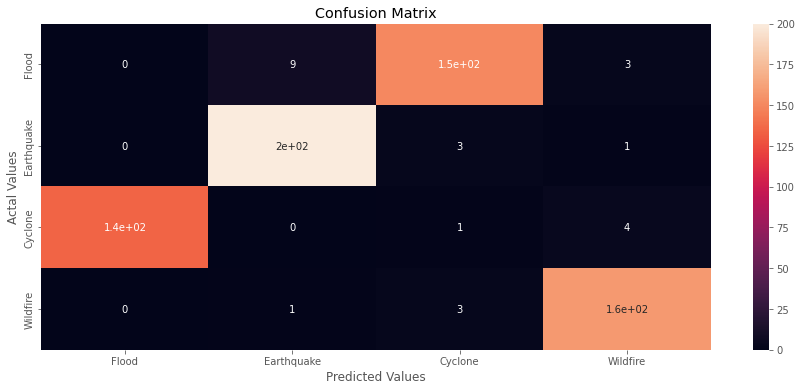

In [38]:
labels =  ['Flood', 'Earthquake', 'Cyclone', 'Wildfire']
conf_matrix = confusion_matrix(y_test_enc,predictions)
display_confusion_matrix(conf_matrix,labels)

In [39]:
model.save('/content/drive/MyDrive/Cyclone_Wildfire_Flood_Earthquake/InceptionV3.h5')